# Capstone Project 2: Twitter Public Opinion Network Analysis for Bungie

This project's goal is to collect and analyze the available Twitter data for Bungie and their main game, Destiny 2.

The data I am collecting are tweets about Bungie and Destiny 2 and the timelines (tweets made by) the Bungie and Destiny 2 official accounts.

This notebook is the data wrangling for the project, mostly calls to the Twitter API (https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html ).

In [1]:
import pandas as pd
from pandas.io.json import json_normalize

import requests
from requests_oauthlib import OAuth1
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime

### Testing Requests

The user rate limit is 180 requests per 15 min for the default api

Here are all of the other rate limits: https://developer.twitter.com/en/docs/basics/rate-limits

This is the base url for the Twitter API

In [2]:
twitter_url = 'https://api.twitter.com/1.1/search/tweets.json'

I will need an API key, secret, token, and token secret, but I will never save them in this file.

There are a couple different authentication methods

I will see which ones I need

https://developer.twitter.com/en/docs/basics/authentication/overview/oauth

The one below is OAuth1

In [3]:
"""
OAuth1('API_KEY',
'API_SECRET_KEY',
'ACCESS_TOKEN',
'ACCESS_TOKEN_SECRET')
"""   
auth = OAuth1()

These are some of the parameters I can use in my requests:

The 'max_id' parameter is very important. max_id roughly correlates with time, so a tweet that has a higher ID than another tweet was made after that tweet. Assigning max_id repeatedly within a loop allows me to prevent repeatedly pulling the same tweets.

In [86]:
params = {
    # General search term
    'q': 'destiny 2',
    
    # Others
    'lang': 'en',
    'result_type': 'recent',
    'count': '100',
    'include_entities': 'false'
}

In [87]:
params

{'count': '100',
 'include_entities': 'false',
 'lang': 'en',
 'max_id': 1100761992720134144L,
 'q': 'destiny 2',
 'result_type': 'recent'}

This request can be used to verify that my credentials worked.

I want to see Response code 200

In [72]:
credential_url = 'https://api.twitter.com/1.1/account/verify_credentials.json'

In [73]:
requests.get(credential_url, auth=auth)

<Response [200]>

Okay, let's pull some tweets

In [88]:
tweets = requests.get(twitter_url, params=params, auth=auth)
tweets

<Response [200]>

Here's the raw JSON

In [89]:
tweets.json()

{u'search_metadata': {u'completed_in': 0.004,
  u'count': 100,
  u'max_id': 1100761992720134144L,
  u'max_id_str': u'1100761992720134144',
  u'query': u'destiny+2',
  u'refresh_url': u'?since_id=1100761992720134144&q=destiny%202&lang=en&result_type=recent',
  u'since_id': 0,
  u'since_id_str': u'0'},
 u'statuses': []}

The json only has 2 top-level keys

In [90]:
tweets.json().keys()

[u'search_metadata', u'statuses']

I don't really need the search metadata. Isolate the tweets themselves

In [96]:
tweets.json()['statuses']

True

In [12]:
tweets.headers

{'content-length': '42276', 'x-rate-limit-reset': '1552439965', 'x-rate-limit-remaining': '179', 'x-xss-protection': '1; mode=block; report=https://twitter.com/i/xss_report', 'x-content-type-options': 'nosniff', 'x-connection-hash': '0506205efaffbeec6b95fd84b15e8532', 'x-twitter-response-tags': 'BouncerCompliant', 'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'status': '200 OK', 'content-disposition': 'attachment; filename=json.json', 'set-cookie': 'personalization_id="v1_0zeROWLiRk16aknnlJ4lxg=="; Max-Age=63072000; Expires=Fri, 12 Mar 2021 01:04:25 GMT; Path=/; Domain=.twitter.com, guest_id=v1%3A155243906564739627; Max-Age=63072000; Expires=Fri, 12 Mar 2021 01:04:25 GMT; Path=/; Domain=.twitter.com', 'expires': 'Tue, 31 Mar 1981 05:00:00 GMT', 'x-access-level': 'read-write', 'last-modified': 'Wed, 13 Mar 2019 01:04:25 GMT', 'pragma': 'no-cache', 'date': 'Wed, 13 Mar 2019 01:04:25 GMT', 'x-rate-limit-limit': '180', 'x-response-time': '324', 'x-trans

Each entry has these fields. Some of the fields (like entities) have several sub-fields.

Some of the engagement metrics are 'favorite_count' and 'retweet_count'

'Created_at' / 'id' will be important for my time-ordering

should I restrict my language to English?

I don't think I can see how many comments there are. Oh I think those are replies. I can self-join or make the network based on 'in_reply_to_status_id_str', I think.

In [13]:
tweets.json()['statuses'][0].keys()

[u'contributors',
 u'truncated',
 u'text',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'retweeted',
 u'coordinates',
 u'source',
 u'in_reply_to_screen_name',
 u'in_reply_to_user_id',
 u'retweet_count',
 u'id_str',
 u'favorited',
 u'retweeted_status',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place',
 u'metadata']

In [14]:
tweets.json()['statuses'][0]['metadata']

{u'iso_language_code': u'en', u'result_type': u'recent'}

Make a dataframe of the tweets

In [15]:
df = json_normalize(tweets.json()['statuses'])
df

contributors coordinates                      created_at  favorite_count  \
0          None        None  Wed Mar 13 01:03:25 +0000 2019               0   
1          None        None  Wed Mar 13 01:02:49 +0000 2019               0   
2          None        None  Wed Mar 13 01:02:24 +0000 2019               2   
3          None        None  Wed Mar 13 01:02:01 +0000 2019               0   
4          None        None  Wed Mar 13 01:01:00 +0000 2019               1   
5          None        None  Wed Mar 13 01:00:46 +0000 2019               0   
6          None        None  Wed Mar 13 01:00:44 +0000 2019               0   
7          None        None  Wed Mar 13 01:00:31 +0000 2019               0   
8          None        None  Wed Mar 13 01:00:04 +0000 2019               0   
9          None        None  Wed Mar 13 01:00:01 +0000 2019               0   
10         None        None  Wed Mar 13 00:57:39 +0000 2019               0   
11         None        None  Wed Mar 13 00:57:06 +0000 2019               0   
12         None        None  Wed Mar 13 00:56:49 +0000 2019               0   
13         None        None  Wed Mar 13 00:55:36 +0000 2019               0   
14         None        None  Wed Mar 13 00:55:15 +0000 2019               0   
15         None        None  Wed Mar 13 00:54:37 +0000 2019               0   
16         None        None  Wed Mar 13 00:54:27 +0000 2019               0   
17         None        None  Wed Mar 13 00:53:05 +0000 2019               0   
18         None        None  Wed Mar 13 00:52:48 +0000 2019               0   
19         None        None  Wed Mar 13 00:52:24 +0000 2019               0   
20         None        None  Wed Mar 13 00:51:54 +0000 2019               2   
21         None        None  Wed Mar 13 00:51:32 +0000 2019               0   
22         None        None  Wed Mar 13 00:51:31 +0000 2019               0   
23         None        None  Wed Mar 13 00:51:26 +0000 2019               1   
24         None        None  Wed Mar 13 00:50:50 +0000 2019               0   
25         None        None  Wed Mar 13 00:50:27 +0000 2019               0   
26         None        None  Wed Mar 13 00:50:22 +0000 2019               1   
27         None        None  Wed Mar 13 00:50:22 +0000 2019               9   
28         None        None  Wed Mar 13 00:49:56 +0000 2019               1   
29         None        None  Wed Mar 13 00:49:30 +0000 2019               0   
..          ...         ...                             ...             ...   
70         None        None  Wed Mar 13 00:21:31 +0000 2019               0   
71         None        None  Wed Mar 13 00:21:16 +0000 2019               0   
72         None        None  Wed Mar 13 00:21:02 +0000 2019               0   
73         None        None  Wed Mar 13 00:20:51 +0000 2019               3   
74         None        None  Wed Mar 13 00:20:49 +0000 2019               0   
75         None        None  Wed Mar 13 00:20:48 +0000 2019               2   
76         None        None  Wed Mar 13 00:20:43 +0000 2019               3   
77         None        None  Wed Mar 13 00:19:55 +0000 2019               0   
78         None        None  Wed Mar 13 00:19:27 +0000 2019               0   
79         None        None  Wed Mar 13 00:19:21 +0000 2019               7   
80         None        None  Wed Mar 13 00:18:24 +0000 2019               0   
81         None        None  Wed Mar 13 00:18:15 +0000 2019               0   
82         None        None  Wed Mar 13 00:16:41 +0000 2019               1   
83         None        None  Wed Mar 13 00:16:10 +0000 2019               1   
84         None        None  Wed Mar 13 00:16:04 +0000 2019               0   
85         None        None  Wed Mar 13 00:15:40 +0000 2019               0   
86         None        None  Wed Mar 13 00:15:34 +0000 2019               1   
87         None        None  Wed Mar 13 00:14:52 +0000 2019               1   
88         None        None  Wed Mar 13 00:14:35 +000

Here is the text of the 100 tweets

In [16]:
df.text

0     RT @TPHDallas: Are you feeling uncertain for w...
1     RT @TheOGPatriotX: Lets get this ball rolling....
2     On tonight's Talking Simulator, Cameron and sp...
3     Destiny 2 news, updates and DLC https://t.co/k...
4     Check out my broadcast from my PlayStation 4! ...
5     Check out my broadcast from my PlayStation 4! ...
6     I WATCHED TOY STORY 1 FOR THE FIRST 3 HOURS OF...
7     An incoming Destiny 2 update will finally buff...
8     Kappa @janpiert1 is playing Destiny 2 at https...
9     RT @TheOGPatriotX: Lets get this ball rolling....
10    RT @FateStayNightUS: The crossroads of destiny...
11    RT @TPHDallas: Are you feeling uncertain for w...
12    Thorn quest and comp #PS4live (Destiny 2)  liv...
13    Check out coolironman97   plays  destiny 2 htt...
14    RT @BPELive: What's does a badass metal man do...
15    👍 on @YouTube: Destiny 2 Lore - Allegiance Qu...
16           @DeeJ_BNG Re-Skin large scale = Destiny 2.
17    RT @TPHDallas: Are you feeling uncertain fo

Plotting favorites vs retweets

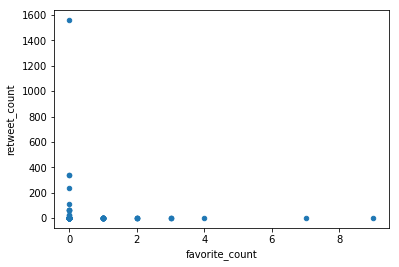

In [17]:
df.plot.scatter(x='favorite_count', y='retweet_count')
plt.show()

Here is how I can access the highest and lowest IDs in a dataframe of tweets.

In [18]:
df.sort_values('id', ascending=True).iloc[0, 6]#.head(1)['id'].values[0]

1105622065724444673

In [19]:
df.sort_values('id', ascending=False).iloc[0, 6]#.head(1)['id'].values[0]

1105635439904473088

In [54]:
df.id.min()

1105622065724444673

In [55]:
df.id.max()

1105635439904473088

### Bias?

I need to have a way to get a representative sample of tweets. I am concerned that if I order tweets by time, this may have bias.

But then the question becomes: How many tweets do I need? I probably shouldn't take them all, since that violates the independence condition of statistical analyses.

### Consideration about IDs

https://developer.twitter.com/en/docs/tweets/timelines/guides/working-with-timelines

The search API will return an ordering based on ID. You should set max_id or since_id to make sure calls aren't redundant.

This seems like it depends on a temporal ordering, like for timelines. 

### Followers

If I want to make a network, I can get accounts' followers. This does depend on having a complete-ish set of data, which may not be possible with the Standard Twitter Search API.

There are a couple requests explained in here: https://developer.twitter.com/en/docs/accounts-and-users/follow-search-get-users/api-reference

Get Followers: Will get all the user IDs for people that follow the account in question

Get Friends: Will get all the user IDs for people that the account in question in following

### Time Sensitivity

Try to get 25k - 50k tweets. I will try to get 20k tweets from each block (Destiny / Bungie).

I can only pull tweets from the last week ish. Getting followers / friendships can happen at any time.

The pokemon / nintendo project idea will be scrapped, since it took too long to figure the duplicate tweet problem out, and the free, standard twitter api only allows access to the last week of data.

I need to figure out how to make sure I get all independent tweets in my data collection.

### Tweet duplication problem

I'm trying to redo and test the loop to eradicate duplicates. 

Testing: does the value for max_id need to be an int or a string? INT

Does the starting value matter? DON"T HAVE A STARTING VALUE

Are there actually just not enough tweets? At len 50, I only had duplicates of some tweets, nothing higher.

at len 100, I only had triples of tweets.

PROBLEM: I was doing a weird dataframe ordering and .iloc to get the lowest tweet, when I should have just taken the ID column as a series and done .min().

#### Code Refactoring

Let's make a function so that this all runs cleaner

In [114]:
def find_tweets_on_topic(topic, block_size, block_num):
    
    # This block should search for any recent tweets involving the input topic
    params = {
        # General search term
        'q': topic,
    
        # Others
        'lang': 'en',
        'result_type': 'recent',
        'count': block_size,
        'include_entities': 'false'
    }
    
    # Set up variables for input later
    twitter_url = 'https://api.twitter.com/1.1/search/tweets.json'
    current_min = float("inf")
    tweets_list = []

    while (len(tweets_list) < block_num):
        # Get the tweets
        tweets = requests.get(twitter_url, params=params, auth=auth)
        
        # If I can't get anymore tweets, be done
        if tweets.json()['statuses'] == []:
            print("Empty Response Found. Exiting Loop.")
            break
            
        # Add tweets to the list
        sub_df = json_normalize(tweets.json()['statuses'])
        tweets_list.append(sub_df)
        
        # Set up max_id on the first time through
        if 'max_id' not in params.keys():
            current_min = sub_df.id.min()
            params['max_id'] = current_min
            # The following line was the old way I found current_min, and is wrong
            #params['max_id'] = sub_df.sort_values('id', ascending=True).iloc[0, 7]
        
        # Change max_id if it is lower than what we currently have
        else:
            new_min = sub_df.id.min()
            if new_min < current_min :
                current_min = new_min
                params['max_id'] = current_min
    
        # I can do 180 requests per 15 minutes
        # This is the same as a request every 5 seconds
        # I will go a little slower than that
        time.sleep(6)
        
    # Make the final dataframe
    tweet_df = pd.concat(tweets_list, sort=False)
    
    # Print statements for performance
    print("Number of tweets: %d" % len(tweet_df.id))
    print("Number of unique tweets: %d" % len(tweet_df.id.drop_duplicates()))
    print("Max number of duplicates: %d" % tweet_df.id.value_counts().values.max())
    
    # Return the dataframe
    return tweet_df

In [31]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 5, 10)

Number of tweets: 46
Number of unique tweets: 46
Max number of duplicates: 1


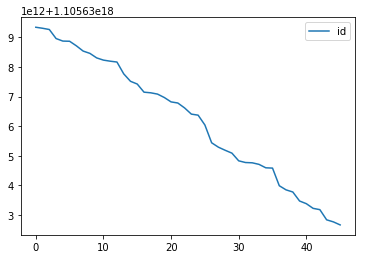

In [34]:
destiny_2_tweet_df.reset_index().plot(y='id')

Result using ID as an int

In [35]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9994
Number of unique tweets: 1122
Max number of duplicates: 10


Result using ID as a string

In [40]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9999
Number of unique tweets: 1109
Max number of duplicates: 11


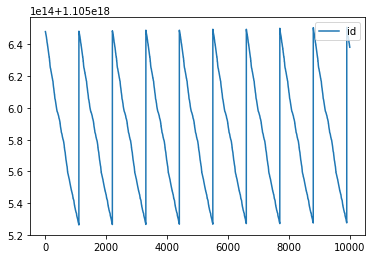

In [41]:
destiny_2_tweet_df.reset_index().plot(y='id')

The oldest tweet in this database is from today, a little earlier than 6 pm. I ran the code around 7:30 pm. I should be able to access tweets older than this.

In [44]:
destiny_2_tweet_df[destiny_2_tweet_df['id'] == destiny_2_tweet_df.id.min()]

contributors coordinates                      created_at  favorite_count  \
99         None         NaN  Tue Mar 12 17:49:37 +0000 2019               0   

    favorited  geo                   id               id_str  \
99      False  NaN  1105526272854237190  1105526272854237190   

   in_reply_to_screen_name  in_reply_to_status_id   ...     \
99                    None                    NaN   ...      

   retweeted_status.place.country_code  retweeted_status.place.full_name  \
99                                 NaN                               NaN   

   retweeted_status.place.id  retweeted_status.place.name  \
99                       NaN                          NaN   

   retweeted_status.place.place_type retweeted_status.place.url  \
99                               NaN                        NaN   

   coordinates.coordinates coordinates.type geo.coordinates geo.type  
99                     NaN              NaN             NaN      NaN  

[1 rows x 296 columns]

In [49]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2500
Number of unique tweets: 1093
Max number of duplicates: 4


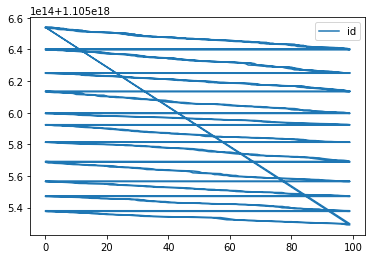

In [53]:
destiny_2_tweet_df.plot(y='id')

Change function to only change the max id if it is lower than the previous one

Since I appear to be gathering repeating tweets

In [61]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2500
Number of unique tweets: 1194
Max number of duplicates: 14


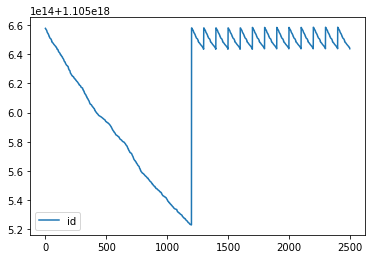

In [64]:
destiny_2_tweet_df.reset_index().plot(y='id')

Changing the max_id parameter to be an integer again.

In [66]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 25)

Number of tweets: 2433
Number of unique tweets: 2409
Max number of duplicates: 2


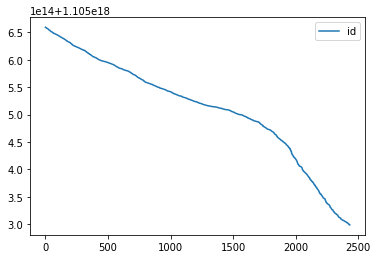

In [67]:
destiny_2_tweet_df.reset_index().plot(y='id')

Hoooooly cow this actually worked.

In [68]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 100)

Number of tweets: 9807
Number of unique tweets: 9708
Max number of duplicates: 2


What happens when I run out of tweets to collect? What do I check?

Let's pass a max_id that I know is over a week old.

In [111]:
params = {
    # General search term
    'q': 'destiny 2',
    
    # Others
    'lang': 'en',
    'result_type': 'recent',
    'count': '100',
    'include_entities': 'false',
    'max_id': 1100761992720134144
}

In [112]:
tweets = requests.get(twitter_url, params=params, auth=auth)
tweets
#tweets.json()['statuses']

<Response [200]>

In [113]:
tweets.headers

{'content-length': '201', 'x-rate-limit-reset': '1552499104', 'x-rate-limit-remaining': '179', 'x-xss-protection': '1; mode=block; report=https://twitter.com/i/xss_report', 'x-content-type-options': 'nosniff', 'x-connection-hash': '0db5c9d9d4ff547d4ce9ae0e057bf6ab', 'x-twitter-response-tags': 'BouncerCompliant', 'cache-control': 'no-cache, no-store, must-revalidate, pre-check=0, post-check=0', 'status': '200 OK', 'content-disposition': 'attachment; filename=json.json', 'set-cookie': 'personalization_id="v1_h8549UZMcp7p2hA9yYEnAw=="; Max-Age=63072000; Expires=Fri, 12 Mar 2021 17:30:04 GMT; Path=/; Domain=.twitter.com, guest_id=v1%3A155249820492196462; Max-Age=63072000; Expires=Fri, 12 Mar 2021 17:30:04 GMT; Path=/; Domain=.twitter.com', 'expires': 'Tue, 31 Mar 1981 05:00:00 GMT', 'x-access-level': 'read-write', 'last-modified': 'Wed, 13 Mar 2019 17:30:04 GMT', 'pragma': 'no-cache', 'date': 'Wed, 13 Mar 2019 17:30:04 GMT', 'x-rate-limit-limit': '180', 'x-response-time': '20', 'x-transact

Okay. So the top-level keys are still present, but the 'statuses' block where the tweets should be is an empty list. I can check for that.

#### Collect official data

In [115]:
destiny_2_tweet_df = find_tweets_on_topic("destiny 2", 100, 250)

Empty Response
Number of tweets: 21661
Number of unique tweets: 21442
Max number of duplicates: 2


In [116]:
bungie_tweet_df = find_tweets_on_topic("bungie", 100, 250)

Number of tweets: 24984
Number of unique tweets: 24735
Max number of duplicates: 2


Cool! I got a lot of tweets. Let's cull the duplicates, reset the index, and make the created_at column a datetime object.

In [126]:
destiny_2_tweet_df = destiny_2_tweet_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(destiny_2_tweet_df)

21442

In [137]:
destiny_2_tweet_df.loc[:, 'created_at'] = \
  [datetime.strptime(destiny_2_tweet_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in destiny_2_tweet_df.index]

In [140]:
bungie_tweet_df = bungie_tweet_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(bungie_tweet_df)

24735

In [142]:
bungie_tweet_df.loc[:, 'created_at'] = \
  [datetime.strptime(bungie_tweet_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in bungie_tweet_df.index]

Save this data!

In [144]:
destiny_2_tweet_df.to_csv('..\\data\\destiny_2_tweets.csv', encoding='utf-8')
bungie_tweet_df.to_csv('..\\data\\bungie_tweets.csv', encoding='utf-8')

What is the earliest tweet found in these dataframes?

In [159]:
print(destiny_2_tweet_df.id.min())
print(bungie_tweet_df.id.min())

1102240804469379075
1102953113022091264


### Timelines

I want to get the Twitter timelines for the twitter accounts of Destiny 2 (@DestinyTheGame) and Bungie (@Bungie).

Let's modify the function above to use the different request. The response json is also different. I don't need to get the statuses in the json, as this response is effectively a list of statuses.

In [160]:
def find_timeline_by_user(screen_name, block_size, block_num):
    
    # This block should search for any recent tweets involving the input topic
    params = {
        # General search term
        'screen_name': screen_name,
    
        # This request can go further back than a week,
        # So I should stop it from doing so
        # This is the earliest tweet in my previous 2 dataframes
        'since_id': 1102240804469379075,
        'count': block_size,
        'exclude_replies': 'false'
    }
    
    # Set up variables for input later
    twitter_url = 'https://api.twitter.com/1.1/statuses/user_timeline.json'
    current_min = float("inf")
    tweets_list = []

    while (len(tweets_list) < block_num):
        # Get the tweets
        tweets = requests.get(twitter_url, params=params, auth=auth)
        
        # If I can't get anymore tweets, be done
        if tweets.json() == []:
            print("Empty Response Found. Exiting Loop.")
            break
            
        # Add tweets to the list
        sub_df = json_normalize(tweets.json())
        tweets_list.append(sub_df)
        
        # Set up max_id on the first time through
        if 'max_id' not in params.keys():
            current_min = sub_df.id.min()
            params['max_id'] = current_min
            # The following line was the old way I found current_min, and is wrong
            #params['max_id'] = sub_df.sort_values('id', ascending=True).iloc[0, 7]
        
        # Change max_id if it is lower than what we currently have
        else:
            new_min = sub_df.id.min()
            if new_min < current_min :
                current_min = new_min
                params['max_id'] = current_min
    
        # I can do 900 requests per 15 minutes
        # This is the same as a request every 1 second
        # I will go a little slower than that
        time.sleep(1.2)
        
    # Make the final dataframe
    tweet_df = pd.concat(tweets_list, sort=False)
    
    # Print statements for performance
    print("Number of tweets: %d" % len(tweet_df.id))
    print("Number of unique tweets: %d" % len(tweet_df.id.drop_duplicates()))
    print("Max number of duplicates: %d" % tweet_df.id.value_counts().values.max())
    
    # Return the dataframe
    return tweet_df

Get timelines for @Bungie and @DestinyTheGame, reset index, insure tweet uniqueness, and set datetimes.

In [161]:
bungie_timeline_df = find_timeline_by_user('Bungie', 200, 100)

Number of tweets: 206
Number of unique tweets: 107
Max number of duplicates: 100


In [166]:
bungie_timeline_df = bungie_timeline_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(bungie_timeline_df)

107

In [167]:
bungie_timeline_df.loc[:, 'created_at'] = \
  [datetime.strptime(bungie_timeline_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in bungie_timeline_df.index]

In [170]:
bungie_timeline_df.to_csv('..\\data\\bungie_timeline.csv', encoding='utf-8')

In [171]:
destiny_2_timeline_df = find_timeline_by_user('DestinyTheGame', 200, 100)

Number of tweets: 145
Number of unique tweets: 46
Max number of duplicates: 100


In [173]:
destiny_2_timeline_df = destiny_2_timeline_df.reset_index(drop=True).drop_duplicates(subset=['id'])
len(destiny_2_timeline_df)

46

In [174]:
destiny_2_timeline_df.loc[:, 'created_at'] = \
  [datetime.strptime(destiny_2_timeline_df.loc[i, 'created_at'][0:-11],
                     "%a %b %d %H:%M:%S").replace(year=2019) for i in destiny_2_timeline_df.index]

In [175]:
destiny_2_timeline_df.to_csv('..\\data\\destiny_2_timeline.csv', encoding='utf-8')

### Import the dataframes back in 

to do some data cleaning.

Get rid of some of the columns so that the data is smaller.

In [2]:
destiny_2_tweet_df = pd.read_csv('..\\data\\destiny_2_tweets.csv', encoding='utf-8', index_col=0)
bungie_tweet_df = pd.read_csv('..\\data\\bungie_tweets.csv', encoding='utf-8', index_col=0)
bungie_timeline_df = pd.read_csv('..\\data\\bungie_timeline.csv', encoding='utf-8', index_col=0)
destiny_2_timeline_df = pd.read_csv('..\\data\\destiny_2_timeline.csv', encoding='utf-8', index_col=0)

C:\Users\sebia\Miniconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,12,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,52,54,56,57,60,61,62,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,83,84,86,90,93,95,99,104,105,106,107,109,111,112,113,114,115,116,117,118,119,120,121,123,125,127,128,131,132,133,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,154,155,157,158,159,160,161,162,163,164,165,166,167,169,171,173,174,177,178,179,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,200,201,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,226,228,232,237,238,239,240,242,244,245,246,247,248,249,250,251,252,253,254,256,258,260,261,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,287,288,290,293,294,295,296,297,298,299,300,301,302,307,308,309,310,311,312,313,314,315,316,317,318,319

Interesting. The destiny tweet df has one more column than the bungie tweet df.

the two timeline dfs have the same number of columns, but with different distributions of dtypes.

In [4]:
destiny_2_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39294 entries, 0 to 21660
Columns: 321 entries, contributors to retweeted_status.quoted_status.place.url
dtypes: float64(75), object(246)
memory usage: 96.5+ MB


In [5]:
bungie_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28335 entries, 0 to 24983
Columns: 320 entries, contributors to retweeted_status.quoted_status.place.url
dtypes: float64(74), int64(1), object(245)
memory usage: 69.4+ MB


In [6]:
bungie_timeline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 106
Columns: 215 entries, contributors to user.verified
dtypes: bool(18), float64(59), int64(13), object(125)
memory usage: 167.4+ KB


In [7]:
destiny_2_timeline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 45
Columns: 215 entries, contributors to user.verified
dtypes: bool(18), float64(62), int64(13), object(122)
memory usage: 72.0+ KB


Let's check column names

This is the column missing from the bungie tweet dataframe. 

In [20]:
set(destiny_2_tweet_df.columns).difference(set(bungie_tweet_df.columns))

{u'retweeted_status.scopes.followers'}

The timeline dataframe has some columns not included in the normal tweet dataframes.

This is because I used a flag in my request parameters to not return entities.

In [22]:
set(bungie_timeline_df.columns).difference(set(bungie_tweet_df.columns))

{u'entities.hashtags',
 u'entities.media',
 u'entities.symbols',
 u'entities.urls',
 u'entities.user_mentions',
 u'extended_entities.media',
 u'quoted_status.entities.hashtags',
 u'quoted_status.entities.media',
 u'quoted_status.entities.symbols',
 u'quoted_status.entities.urls',
 u'quoted_status.entities.user_mentions',
 u'quoted_status.extended_entities.media',
 u'retweeted_status.entities.hashtags',
 u'retweeted_status.entities.media',
 u'retweeted_status.entities.symbols',
 u'retweeted_status.entities.urls',
 u'retweeted_status.entities.user_mentions',
 u'retweeted_status.extended_entities.media'}

The tweet dataframe has a lot of columns not present in the timeline dataframe.

Most notable is that none of the timeline tweets appear to be retweets, since a huge chunk of the column names not present in the timeline dataframe start with 'retweeted_status.'

In [23]:
set(bungie_tweet_df.columns).difference(set(bungie_timeline_df.columns))

{u'coordinates.coordinates',
 u'coordinates.type',
 u'geo.coordinates',
 u'geo.type',
 u'metadata.iso_language_code',
 u'metadata.result_type',
 u'place.bounding_box.coordinates',
 u'place.bounding_box.type',
 u'place.contained_within',
 u'place.country',
 u'place.country_code',
 u'place.full_name',
 u'place.id',
 u'place.name',
 u'place.place_type',
 u'place.url',
 u'quoted_status.metadata.iso_language_code',
 u'quoted_status.metadata.result_type',
 u'quoted_status.place.bounding_box.coordinates',
 u'quoted_status.place.bounding_box.type',
 u'quoted_status.place.contained_within',
 u'quoted_status.place.country',
 u'quoted_status.place.country_code',
 u'quoted_status.place.full_name',
 u'quoted_status.place.id',
 u'quoted_status.place.name',
 u'quoted_status.place.place_type',
 u'quoted_status.place.url',
 u'quoted_status.quoted_status_id',
 u'quoted_status.quoted_status_id_str',
 u'retweeted_status.metadata.iso_language_code',
 u'retweeted_status.metadata.result_type',
 u'retweeted_s

Look at all of the column names

In [25]:
print(destiny_2_tweet_df.columns.values)

[u'contributors' u'coordinates' u'created_at' u'favorite_count'
 u'favorited' u'geo' u'id' u'id_str' u'in_reply_to_screen_name'
 u'in_reply_to_status_id' u'in_reply_to_status_id_str'
 u'in_reply_to_user_id' u'in_reply_to_user_id_str' u'is_quote_status'
 u'lang' u'metadata.iso_language_code' u'metadata.result_type' u'place'
 u'possibly_sensitive' u'quoted_status.contributors'
 u'quoted_status.coordinates' u'quoted_status.created_at'
 u'quoted_status.favorite_count' u'quoted_status.favorited'
 u'quoted_status.geo' u'quoted_status.id' u'quoted_status.id_str'
 u'quoted_status.in_reply_to_screen_name'
 u'quoted_status.in_reply_to_status_id'
 u'quoted_status.in_reply_to_status_id_str'
 u'quoted_status.in_reply_to_user_id'
 u'quoted_status.in_reply_to_user_id_str' u'quoted_status.is_quote_status'
 u'quoted_status.lang' u'quoted_status.metadata.iso_language_code'
 u'quoted_status.metadata.result_type' u'quoted_status.place'
 u'quoted_status.possibly_sensitive' u'quoted_status.retweet_count'
 u

In [111]:
print(destiny_2_timeline_df.columns.values)

[u'contributors' u'coordinates' u'created_at' u'entities.hashtags'
 u'entities.media' u'entities.symbols' u'entities.urls'
 u'entities.user_mentions' u'extended_entities.media' u'favorite_count'
 u'favorited' u'geo' u'id' u'id_str' u'in_reply_to_screen_name'
 u'in_reply_to_status_id' u'in_reply_to_status_id_str'
 u'in_reply_to_user_id' u'in_reply_to_user_id_str' u'is_quote_status'
 u'lang' u'place' u'possibly_sensitive' u'quoted_status.contributors'
 u'quoted_status.coordinates' u'quoted_status.created_at'
 u'quoted_status.entities.hashtags' u'quoted_status.entities.media'
 u'quoted_status.entities.symbols' u'quoted_status.entities.urls'
 u'quoted_status.entities.user_mentions'
 u'quoted_status.extended_entities.media' u'quoted_status.favorite_count'
 u'quoted_status.favorited' u'quoted_status.geo' u'quoted_status.id'
 u'quoted_status.id_str' u'quoted_status.in_reply_to_screen_name'
 u'quoted_status.in_reply_to_status_id'
 u'quoted_status.in_reply_to_status_id_str'
 u'quoted_status.in_

Let's see if there are NaN values anywhere.

So apparently there are a lot more tweets than I thought there would be. The data collection function said I had 21661 tweets in the destiny_2_tweet_df, and 21444 were unique. I saved the dataframe after I called drop_duplicates on the id column, so I don't know why I have more tweets now.

This is also true of bungie_tweet_df, but at a smaller scale.

The timeline dataframes have as many tweets as I expect.

There are also NaN values in every row. 

In [32]:
print("There are %d entries in the dataframe, %d of which do not have any NaN values, and %d of which are unique." %
    (len(destiny_2_tweet_df), len(destiny_2_tweet_df.dropna()), len(destiny_2_tweet_df.drop_duplicates(subset=['id']))))

There are 39294 entries in the dataframe, 0 of which do not have any NaN values, and 21444 of which are unique.


In [33]:
print("There are %d entries in the dataframe, %d of which do not have any NaN values, and %d of which are unique." %
    (len(bungie_tweet_df), len(bungie_tweet_df.dropna()), len(bungie_tweet_df.drop_duplicates(subset=['id']))))

There are 28335 entries in the dataframe, 0 of which do not have any NaN values, and 24738 of which are unique.


In [34]:
print("There are %d entries in the dataframe, %d of which do not have any NaN values, and %d of which are unique." %
    (len(bungie_timeline_df), len(bungie_timeline_df.dropna()), len(bungie_timeline_df.drop_duplicates(subset=['id']))))

There are 107 entries in the dataframe, 0 of which do not have any NaN values, and 107 of which are unique.


In [35]:
print("There are %d entries in the dataframe, %d of which do not have any NaN values, and %d of which are unique." %
    (len(destiny_2_timeline_df), len(destiny_2_timeline_df.dropna()), len(destiny_2_timeline_df.drop_duplicates(subset=['id']))))

There are 46 entries in the dataframe, 0 of which do not have any NaN values, and 46 of which are unique.


Drop duplicates seems to fix the problem

In [38]:
destiny_2_tweet_df = destiny_2_tweet_df.drop_duplicates(subset=['id'])
len(destiny_2_tweet_df)

21444

In [39]:
bungie_tweet_df = bungie_tweet_df.drop_duplicates(subset=['id'])
len(bungie_tweet_df)

24738

### Trim Down the Dataframes

I should make only the dataframes involve a smaller number of columns.

I ran through the columns 20 at a time to see what seemed relevant. If I needed clarification on the data in that column, I would look at it in the cell below my list of columns_desired.

Most of the columns are objects like users and tweet parameters (text, retweet count, favorite count, etc) repeated for tweets that are retweets, quotes, and combinations of the two.

In [108]:
destiny_2_tweet_df.columns[300:]

Index([u'retweeted_status.place.place_type', u'retweeted_status.place.url',
       u'quoted_status.quoted_status_id',
       u'quoted_status.quoted_status_id_str',
       u'retweeted_status.quoted_status.quoted_status_id',
       u'retweeted_status.quoted_status.quoted_status_id_str',
       u'coordinates.coordinates', u'coordinates.type', u'geo.coordinates',
       u'geo.type', u'retweeted_status.scopes.followers',
       u'retweeted_status.quoted_status.place.bounding_box.coordinates',
       u'retweeted_status.quoted_status.place.bounding_box.type',
       u'retweeted_status.quoted_status.place.contained_within',
       u'retweeted_status.quoted_status.place.country',
       u'retweeted_status.quoted_status.place.country_code',
       u'retweeted_status.quoted_status.place.full_name',
       u'retweeted_status.quoted_status.place.id',
       u'retweeted_status.quoted_status.place.name',
       u'retweeted_status.quoted_status.place.place_type',
       u'retweeted_status.quoted_statu

These columns are for retweets of quotes, in case I really want them.

In [107]:
columns_desired = ['retweeted_status.quoted_status.created_at',
                   'retweeted_status.quoted_status.favorite_count', 'retweeted_status.quoted_status.id',
                   'retweeted_status.quoted_status.in_reply_to_screen_name', 'retweeted_status.quoted_status.in_reply_to_status_id',
                   'retweeted_status.quoted_status.retweet_count', 'retweeted_status.quoted_status.text', 
                   'retweeted_status.quoted_status.user.followers_count', 'retweeted_status.quoted_status.user.friends_count',
                   'retweeted_status.quoted_status.user.following', 'retweeted_status.quoted_status.user.id', 
                   'retweeted_status.quoted_status.user.name', 'retweeted_status.quoted_status.user.verified',
                   'retweeted_status.quoted_status_id']

These columns are the ones I want.

In [122]:
# Start with columns for basic tweets
columns_desired = ['id', 'created_at', 'text', 'user.id', 'user.name', 'user.screen_name',
                   'user.followers_count', 'user.friends_count', 'user.statuses_count', 'user.verified', 'favorite_count',
                   'retweet_count', 'retweeted', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_user_id',
                   # Columns for quoted tweets
                   'is_quote_status', 'quoted_status.id', 'quoted_status.created_at',
                   'quoted_status.text', 'quoted_status.user.id', 'quoted_status.user.followers_count', 
                   'quoted_status.user.friends_count', 'quoted_status.user.statuses_count', 'quoted_status.user.verified',
                   'quoted_status.favorite_count', 'quoted_status.retweet_count', 'quoted_status.retweeted',
                   'quoted_status.in_reply_to_screen_name', 'quoted_status.in_reply_to_status_id',
                   'quoted_status.in_reply_to_user_id', 'quoted_status_id',
                   'quoted_status.user.following', 'quoted_status.is_quote_status', 
                   # Columns for retweets
                   'retweeted_status.id', 'retweeted_status.created_at', 
                   'retweeted_status.user.id', 'retweeted_status.user.followers_count', 
                   'retweeted_status.user.friends_count', 'retweeted_status.user.statuses_count', 
                   'retweeted_status.user.verified', 'retweeted_status.favorite_count', 'retweeted_status.retweet_count',
                   'retweeted_status.retweeted', 'retweeted_status.in_reply_to_screen_name',
                   'retweeted_status.in_reply_to_status_id', 'retweeted_status.in_reply_to_user_id', 
                   'retweeted_status.user.following', 'retweeted_status.is_quote_status', 'retweeted_status.favorited'
                   # Columns for retweets of quotes
                   # Do I really need these?
                   # There are only 400 ish
                   # NVM, I've decided this isn't worth it.
                  ]

This cell is where I check the details of certain columns, if it isn't clear to me what the column is.

In [116]:
destiny_2_tweet_df['retweeted_status.quoted_status.created_at'].dropna()

127      Wed Mar 13 13:54:18 +0000 2019
180      Tue Mar 12 14:07:49 +0000 2019
185      Wed Mar 13 13:54:18 +0000 2019
227      Wed Mar 13 13:54:18 +0000 2019
299      Tue Mar 12 16:18:08 +0000 2019
342      Tue Mar 12 14:07:49 +0000 2019
369      Wed Mar 13 03:34:49 +0000 2019
455      Wed Mar 13 11:17:33 +0000 2019
624      Wed Mar 13 07:55:59 +0000 2019
626      Wed Mar 13 07:55:59 +0000 2019
653      Tue Mar 12 22:28:54 +0000 2019
673      Mon Feb 18 16:01:40 +0000 2019
812      Mon Feb 18 16:01:40 +0000 2019
828      Mon Feb 18 16:01:40 +0000 2019
874      Tue Mar 12 23:28:47 +0000 2019
990      Mon Feb 18 16:01:40 +0000 2019
1026     Mon Feb 18 16:01:40 +0000 2019
1081     Wed Mar 13 01:06:59 +0000 2019
1101     Mon Feb 18 16:01:40 +0000 2019
1191     Mon Feb 18 16:01:40 +0000 2019
1230     Mon Feb 18 16:01:40 +0000 2019
1317     Mon Feb 18 16:01:40 +0000 2019
1369     Tue Mar 12 14:07:49 +0000 2019
1409     Sat Oct 13 10:34:12 +0000 2018
1417     Sat Oct 13 10:34:12 +0000 2018


What on Earth is this?? I think the data got misaligned or something, so I need to throw this piece of data out.

In [57]:
destiny_2_tweet_df[destiny_2_tweet_df['metadata.result_type'] == 4740701623]

contributors coordinates  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...         True       False   

                                                                        created_at  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...  Mon Jan 11 00:19:53 +0000 2016   

                                                   favorite_count  favorited  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...           True        0.0   

                                                                                                  geo  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...  The cheapest games on the internet! (UP TO 90%...   

                                                    id  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...  []   

                                                                                               id_str  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...  [{u'url': u'https://t.co/CRHriqCRjB', u'indice...   

                                                   in_reply_to_screen_name  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                     245   

                                                   in_reply_to_status_id  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                 False   

                                                                     ...                     \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                   ...                      

                                                    retweeted_status.quoted_status.place.bounding_box.coordinates  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                                NaN               

                                                   retweeted_status.quoted_status.place.bounding_box.type  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                                NaN       

                                                    retweeted_status.quoted_status.place.contained_within  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                                NaN       

                                                    retweeted_status.quoted_status.place.country  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                           NaN   

                                                   retweeted_status.quoted_status.place.country_code  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                               NaN   

                                                   retweeted_status.quoted_status.place.full_name  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                            NaN   

                                                   retweeted_status.quoted_status.place.id  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                     NaN   

                                                   retweeted_status.quoted_status.place.name  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                       NaN   

                                                   retweeted_status.quoted_status.place.place_type  \
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                             NaN   

                                                   retweeted_status.quoted_status.place.url  
 @ShoutGamers @ShoutRTs @FameRTR @DNRCREWx… htt...                                      NaN  

[1 rows x 321 columns]

In [59]:
destiny_2_tweet_df = destiny_2_tweet_df.drop(destiny_2_tweet_df[destiny_2_tweet_df['metadata.result_type'] == 4740701623].index
                                             , axis=0)

#### Time to get the column subset

Useful, I have found out that all the coordinates and contributor columns are entirely null, so I can take them out.

In [121]:
destiny_2_tweet_min_df = destiny_2_tweet_df[columns_desired]
destiny_2_tweet_min_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21443 entries, 0 to 21660
Data columns (total 54 columns):
id                                          21442 non-null object
created_at                                  21442 non-null object
contributors                                0 non-null object
coordinates                                 0 non-null object
text                                        21440 non-null object
user.id                                     21439 non-null float64
user.name                                   21439 non-null object
user.screen_name                            21439 non-null object
user.followers_count                        21439 non-null float64
user.friends_count                          21439 non-null float64
user.statuses_count                         21439 non-null float64
user.verified                               21439 non-null object
favorite_count                              21442 non-null object
retweet_count                             

Take 2

In [125]:
destiny_2_tweet_min_df = destiny_2_tweet_df[columns_desired]
destiny_2_tweet_min_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21443 entries, 0 to 21660
Data columns (total 50 columns):
id                                          21442 non-null object
created_at                                  21442 non-null object
text                                        21440 non-null object
user.id                                     21439 non-null float64
user.name                                   21439 non-null object
user.screen_name                            21439 non-null object
user.followers_count                        21439 non-null float64
user.friends_count                          21439 non-null float64
user.statuses_count                         21439 non-null float64
user.verified                               21439 non-null object
favorite_count                              21442 non-null object
retweet_count                               21442 non-null float64
retweeted                                   21442 non-null object
in_reply_to_screen_name          

In [126]:
bungie_tweet_min_df = bungie_tweet_df[columns_desired]
bungie_tweet_min_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24738 entries, 0 to 24983
Data columns (total 50 columns):
id                                          24738 non-null int64
created_at                                  24738 non-null object
text                                        24735 non-null object
user.id                                     24730 non-null float64
user.name                                   24729 non-null object
user.screen_name                            24730 non-null object
user.followers_count                        24730 non-null float64
user.friends_count                          24730 non-null float64
user.statuses_count                         24730 non-null float64
user.verified                               24730 non-null object
favorite_count                              24738 non-null object
retweet_count                               24735 non-null float64
retweeted                                   24735 non-null object
in_reply_to_screen_name           

In [128]:
bungie_timeline_min_df = bungie_timeline_df[columns_desired]
bungie_timeline_min_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 106
Data columns (total 50 columns):
id                                          107 non-null int64
created_at                                  107 non-null object
text                                        107 non-null object
user.id                                     107 non-null int64
user.name                                   107 non-null object
user.screen_name                            107 non-null object
user.followers_count                        107 non-null int64
user.friends_count                          107 non-null int64
user.statuses_count                         107 non-null int64
user.verified                               107 non-null bool
favorite_count                              107 non-null int64
retweet_count                               107 non-null int64
retweeted                                   107 non-null bool
in_reply_to_screen_name                     79 non-null object
in_reply_to

In [129]:
destiny_2_timeline_min_df = destiny_2_timeline_df[columns_desired]
destiny_2_timeline_min_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 45
Data columns (total 50 columns):
id                                          46 non-null int64
created_at                                  46 non-null object
text                                        46 non-null object
user.id                                     46 non-null int64
user.name                                   46 non-null object
user.screen_name                            46 non-null object
user.followers_count                        46 non-null int64
user.friends_count                          46 non-null int64
user.statuses_count                         46 non-null int64
user.verified                               46 non-null bool
favorite_count                              46 non-null int64
retweet_count                               46 non-null int64
retweeted                                   46 non-null bool
in_reply_to_screen_name                     29 non-null object
in_reply_to_status_id     

Excellent. I have gone from 200-300 columns in each dataframe to 50, and they all have the same columns now. That will be very useful.

I can tell that most tweets aren't retweets or quotes, since most of the entries in those columns are null. What should I put those entries as?

#### Save the new data

I accidentally overwrote bungie_tweets.csv, oh well.

In [131]:
destiny_2_tweet_min_df.to_csv("..\\data\\destiny_2_tweets_min.csv", encoding='utf-8')
bungie_tweet_min_df.to_csv("..\\data\\bungie_tweets_min.csv", encoding='utf-8')
bungie_timeline_min_df.to_csv("..\\data\\bungie_timeline_min.csv", encoding='utf-8')
destiny_2_timeline_min_df.to_csv("..\\data\\destiny_2_timeline_min.csv", encoding='utf-8')